In [ ]:
import numpy as np
import torch
import glob
import os
import json
import sys
import torch.utils.data as utils
PROJECT_SRC_DIR = '/cluster/tufts/hugheslab/prath01/projects/time_series_prediction/src/'
sys.path.append(PROJECT_SRC_DIR)
sys.path.append(os.path.join(PROJECT_SRC_DIR, "rnn"))
sys.path.append(os.path.join(PROJECT_SRC_DIR, "GRU_D"))
sys.path.append(os.path.abspath("../src"))
from feature_transformation import parse_id_cols, parse_output_cols, parse_feature_cols, parse_id_cols, parse_time_cols
import pandas as pd
from split_dataset import split_dataframe_by_keys
from dataset_loader import TidySequentialDataCSVLoader
from GRU_D import GRUD
from GRUD_model import grud_model
from sklearn.metrics import roc_auc_score, average_precision_score
import copy
from impute_missing_values_and_normalize_data import get_time_since_last_observed_features, compute_time_since_last_observed, update_data_dict_with_mask_features, update_data_dict_with_mask_features, normalize_df
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

## Load MIMIC

In [2]:
train_test_dir = '/cluster/tufts/hugheslab/prath01/projects/time_series_prediction/datasets/mimic3_inhospital_mortality/v20201207/split-by=subject_id/features_per_timeslice/classifier_train_test_split_dir/'
x_dict_file = '/cluster/tufts/hugheslab/prath01/projects/time_series_prediction/datasets/mimic3_inhospital_mortality/v20201207/split-by=subject_id/features_per_timeslice/classifier_train_test_split_dir/x_dict_imputed.json'
y_dict_file = '/cluster/tufts/hugheslab/prath01/projects/time_series_prediction/datasets/mimic3_inhospital_mortality/v20201207/split-by=subject_id/features_per_timeslice/classifier_train_test_split_dir/y_dict.json'

In [3]:
# !ls /cluster/tufts/hugheslab/prath01/projects/time_series_prediction/datasets/mimic3_inhospital_mortality/v20201207/split-by=subject_id/features_per_timeslice/classifier_train_test_split_dir/*imputed*
x_train_csv_filename = os.path.join(train_test_dir, 'x_train_first_24_hours_imputed.csv')
y_train_csv_filename = os.path.join(train_test_dir, 'y_train_first_24_hours.csv')
x_train_df = pd.read_csv(x_train_csv_filename)
y_train_df = pd.read_csv(y_train_csv_filename)

x_valid_csv_filename = os.path.join(train_test_dir, 'x_valid_first_24_hours_imputed.csv')
y_valid_csv_filename = os.path.join(train_test_dir, 'y_valid_first_24_hours.csv')
x_valid_df = pd.read_csv(x_valid_csv_filename)
y_valid_df = pd.read_csv(y_valid_csv_filename)

x_test_csv_filename = os.path.join(train_test_dir, 'x_test_first_24_hours_imputed.csv')
y_test_csv_filename = os.path.join(train_test_dir, 'y_test_first_24_hours.csv')
x_test_df = pd.read_csv(x_test_csv_filename)
y_test_df = pd.read_csv(y_test_csv_filename)

x_data_dict = json.load(open(x_dict_file))
y_data_dict = json.load(open(y_dict_file))

feature_cols = parse_feature_cols(x_data_dict['schema'])
id_cols = parse_id_cols(x_data_dict['schema'])

## Load toy data

In [2]:
def update_data_dict_with_mask_features(x_data_dict):
    # add the new features to the data dict
    
    feature_cols = parse_feature_cols(x_data_dict['schema'])
    time_col = parse_time_cols(x_data_dict['schema'])
    id_cols = parse_id_cols(x_data_dict['schema'])
    
    new_fields=[]
    for col in x_data_dict['schema']['fields']:
        if col['name']==time_col:
            new_fields.append(dict(col))
        
        if col['name'] in id_cols:
            new_fields.append(dict(col))
        
        if col['name'] in feature_cols:
            for missing_feature in ['', 'mask_', 'delta_']:
                new_dict = dict(col)
                new_dict['name'] = '{}{}'.format(missing_feature, col['name'])
                new_fields.append(new_dict)
     

    new_data_dict = copy.deepcopy(x_data_dict)
    new_data_dict['schema']['fields'] = new_fields
    new_data_dict['fields'] = new_fields
        
    return new_data_dict

In [27]:
train_test_dir = "/cluster/tufts/hugheslab/prath01/projects/time_series_prediction/datasets/toy_overheat/v20200515/train_test_split_dir/"
x_train_csv_filename = os.path.join(train_test_dir, 'x_train_no_imp.csv')
y_train_csv_filename = os.path.join(train_test_dir, 'y_train_no_imp.csv')
x_train_df = pd.read_csv(x_train_csv_filename)
y_train_df = pd.read_csv(y_train_csv_filename)

x_valid_csv_filename = os.path.join(train_test_dir, 'x_valid_no_imp.csv')
y_valid_csv_filename = os.path.join(train_test_dir, 'y_valid_no_imp.csv')
x_valid_df = pd.read_csv(x_valid_csv_filename)
y_valid_df = pd.read_csv(y_valid_csv_filename)

x_test_csv_filename = os.path.join(train_test_dir, 'x_test_no_imp.csv')
y_test_csv_filename = os.path.join(train_test_dir, 'y_test_no_imp.csv')
x_test_df = pd.read_csv(x_test_csv_filename)
y_test_df = pd.read_csv(y_test_csv_filename)

x_dict_file = os.path.join(train_test_dir, 'x_dict.json')
y_dict_file = os.path.join(train_test_dir, 'y_dict.json')
x_data_dict = json.load(open(x_dict_file))
y_data_dict = json.load(open(y_dict_file))

raw_feature_cols = parse_feature_cols(x_data_dict['schema'])
time_col = parse_time_cols(x_data_dict['schema'])
id_cols = parse_id_cols(x_data_dict['schema'])

for feature_col in raw_feature_cols:
    x_train_df.loc[:, 'mask_'+feature_col] = (~x_train_df[feature_col].isna())*1
    x_valid_df.loc[:, 'mask_'+feature_col] = (~x_valid_df[feature_col].isna())*1
    x_test_df.loc[:, 'mask_'+feature_col] = (~x_test_df[feature_col].isna())*1
print('Adding time since last missing value is observed as features...')
x_train_df = get_time_since_last_observed_features(x_train_df, id_cols, time_col, raw_feature_cols)
x_valid_df = get_time_since_last_observed_features(x_valid_df, id_cols, time_col, raw_feature_cols)
x_test_df = get_time_since_last_observed_features(x_test_df, id_cols, time_col, raw_feature_cols)


# impute values
print('Imputing values in train and test sets separately..')
x_train_df = x_train_df.groupby(id_cols).apply(lambda x: x.fillna(method='pad')).copy()
x_valid_df = x_valid_df.groupby(id_cols).apply(lambda x: x.fillna(method='pad')).copy()
x_test_df = x_test_df.groupby(id_cols).apply(lambda x: x.fillna(method='pad')).copy()

for feature_col in raw_feature_cols:
    x_train_df[feature_col].fillna(x_train_df[feature_col].mean(), inplace=True)

    # impute population mean of training set to test set
    x_valid_df[feature_col].fillna(x_train_df[feature_col].mean(), inplace=True)
    x_test_df[feature_col].fillna(x_train_df[feature_col].mean(), inplace=True)

# Update data dict with missing value features
new_data_dict = update_data_dict_with_mask_features(x_data_dict)

# get feature columns with mask features
feature_cols_with_mask_features = parse_feature_cols(new_data_dict)

# normalize the data
# x_train_normalized_df, scaling_df = normalize_df(x_train_df, feature_cols_with_mask_features, scaling='zscore')
# x_valid_normalized_df, scaling_df = normalize_df(x_valid_df, feature_cols_with_mask_features, scaling='zscore', train_df=x_train_df)
# x_test_normalized_df, scaling_df = normalize_df(x_test_df, feature_cols_with_mask_features, scaling='zscore', train_df=x_train_df)

# x_train_df = x_train_normalized_df.copy()
# x_valid_df = x_valid_normalized_df.copy()
# x_test_df = x_test_normalized_df.copy()

feature_cols = feature_cols_with_mask_features.copy()

100% |########################################################################|
100% |########################################################################|


Adding time since last missing value is observed as features...
Imputing values in train and test sets separately..


In [28]:
x_train_df

,sequence_id,timestep,temperature_1,temperature_2,mask_temperature_1,mask_temperature_2,delta_temperature_1,delta_temperature_2
0,0,0,0.036099,-0.843155,1,0,0,0
1,0,1,0.036099,0.168792,0,1,1,1
2,0,2,0.036099,-0.148642,0,1,2,1
3,0,3,0.036099,-1.500178,0,1,3,1
4,0,4,8.496983,-1.203854,1,1,4,1
...,...,...,...,...,...,...,...,...
2011,349,3,8.498435,-1.829326,1,1,1,2
2012,349,4,13.713242,0.103477,1,1,1,1
2013,349,5,23.855439,0.103477,1,0,1,1
2014,349,6,23.818067,-0.004375,1,1,1,2


# begin training

In [64]:
mask_feature_cols = [col for col in feature_cols if 'mask_' in col]
delta_feature_cols = [col for col in feature_cols if 'delta_' in col]
raw_feature_cols = [col for col in feature_cols if (col not in mask_feature_cols)&(col not in delta_feature_cols)]

In [65]:
#did_overheat_binary_label   mort_hosp
train_vitals = TidySequentialDataCSVLoader(
    x_csv_path=x_train_df,
    y_csv_path=y_train_df,
    x_col_names=feature_cols,
    idx_col_names=id_cols,
    y_col_name="did_overheat_binary_label",
    y_label_type='per_sequence'
)

valid_vitals = TidySequentialDataCSVLoader(
    x_csv_path=x_valid_df,
    y_csv_path=y_valid_df,
    x_col_names=feature_cols,
    idx_col_names=id_cols,
    y_col_name="did_overheat_binary_label",
    y_label_type='per_sequence'
)

test_vitals = TidySequentialDataCSVLoader(
    x_csv_path=x_test_df,
    y_csv_path=y_test_df,
    x_col_names=feature_cols,
    idx_col_names=id_cols,
    y_col_name="did_overheat_binary_label",
    y_label_type='per_sequence'
)

In [66]:
x_train_df

,sequence_id,timestep,temperature_1,temperature_2,mask_temperature_1,mask_temperature_2,delta_temperature_1,delta_temperature_2
0,0,0,0.036099,-0.843155,1,0,0,0
1,0,1,0.036099,0.168792,0,1,1,1
2,0,2,0.036099,-0.148642,0,1,2,1
3,0,3,0.036099,-1.500178,0,1,3,1
4,0,4,8.496983,-1.203854,1,1,4,1
...,...,...,...,...,...,...,...,...
2011,349,3,8.498435,-1.829326,1,1,1,2
2012,349,4,13.713242,0.103477,1,1,1,1
2013,349,5,23.855439,0.103477,1,0,1,1
2014,349,6,23.818067,-0.004375,1,1,1,2


In [67]:
X_train, y_train = train_vitals.get_batch_data(batch_id=0)
X_valid, y_valid = valid_vitals.get_batch_data(batch_id=0)
X_test, y_test = test_vitals.get_batch_data(batch_id=0)

In [68]:
N_train, T, F = X_train.shape
N_valid, T, F = X_valid.shape
N_test, T, F = X_test.shape

In [69]:
print(N_train)
print(N_valid)
print(N_test)



252
45
53


In [70]:
X_train.shape

(252, 8, 6)

In [71]:
num_true_feats = int(F/3)
X_train_reshaped = np.zeros((N_train, 3, T, num_true_feats))
X_valid_reshaped = np.zeros((N_valid, 3, T, num_true_feats))
X_test_reshaped = np.zeros((N_test, 3, T, num_true_feats))
for ii in range(3):
    X_train_reshaped[:, ii, :, :] = X_train[:, :, num_true_feats*ii:num_true_feats*(ii+1)].copy()
    X_valid_reshaped[:, ii, :, :] = X_valid[:, :, num_true_feats*ii:num_true_feats*(ii+1)].copy()
    X_test_reshaped[:, ii, :, :] = X_test[:, :, num_true_feats*ii:num_true_feats*(ii+1)].copy()
X_train_reshaped = np.transpose(X_train_reshaped, (0, 1, 3, 2))
X_valid_reshaped = np.transpose(X_valid_reshaped, (0, 1, 3, 2))
X_test_reshaped = np.transpose(X_test_reshaped, (0, 1, 3, 2))


In [105]:
def data_dataloader(train_data, train_outcomes, valid_data, valid_outcomes, test_data, test_outcomes, batch_size=512):
    
    
    # ndarray to tensor
    train_data, train_label = torch.Tensor(train_data), torch.Tensor(train_outcomes[:, np.newaxis])
    dev_data, dev_label = torch.Tensor(valid_data), torch.Tensor(valid_outcomes[:, np.newaxis])
    test_data, test_label = torch.Tensor(test_data), torch.Tensor(test_outcomes[:, np.newaxis])
    
    # tensor to dataset
    train_dataset = utils.TensorDataset(train_data, train_label)
    dev_dataset = utils.TensorDataset(dev_data, dev_label)
    test_dataset = utils.TensorDataset(test_data, test_label)
    
    # dataset to dataloader 
    train_dataloader = utils.DataLoader(train_dataset, batch_size=batch_size)
    dev_dataloader = utils.DataLoader(dev_dataset, batch_size=batch_size)
    test_dataloader = utils.DataLoader(test_dataset, batch_size=batch_size)
    
    print("train_data.shape : {}\t train_label.shape : {}".format(train_data.shape, train_label.shape))
    print("dev_data.shape : {}\t dev_label.shape : {}".format(dev_data.shape, dev_label.shape))
    print("test_data.shape : {}\t test_label.shape : {}".format(test_data.shape, test_label.shape))
    
    return train_dataloader, dev_dataloader, test_dataloader

In [106]:
train_dataloader, valid_dataloader, test_dataloader = data_dataloader(X_train_reshaped, y_train, 
                                                                      X_valid_reshaped, y_valid,
                                                                      X_test_reshaped, y_test, 252)

train_data.shape : torch.Size([252, 3, 2, 8])	 train_label.shape : torch.Size([252, 1])
dev_data.shape : torch.Size([45, 3, 2, 8])	 dev_label.shape : torch.Size([45, 1])
test_data.shape : torch.Size([53, 3, 2, 8])	 test_label.shape : torch.Size([53, 1])


In [107]:
def fit(model, criterion, learning_rate,\
        train_dataloader, dev_dataloader, test_dataloader,\
        learning_rate_decay=0, n_epochs=30, weight_decay=0):
    epoch_losses = []
    epoch_perfs = []
    
    # to check the update 
    old_state_dict = {}
    for key in model.state_dict():
        old_state_dict[key] = model.state_dict()[key].clone()
    
    for epoch in range(n_epochs):
        
        if learning_rate_decay != 0:

            # every [decay_step] epoch reduce the learning rate by half
            if  epoch % learning_rate_decay == 0:
                learning_rate = learning_rate/2
                optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
                print('at epoch {} learning_rate is updated to {}'.format(epoch, learning_rate))
        
        # train the model
        losses, acc = [], []
        label, pred = [], []
        y_pred_col= []
        model.train()
        for train_data, train_label in train_dataloader: 
            model.train() 
            #push current sample to GPU or CPU 
            train_data, train_label = train_data.to("cpu"), train_label.to("cpu") 
            # Zero the parameter gradients 
            optimizer.zero_grad() 
            # Forward pass : Compute predicted y by passing train data to the model 
            y_pred = model(train_data)[:,-1,:] #last output 
            
            
            # Save predict and label
            y_pred_col.append(y_pred.detach().numpy())
            pred.append((y_pred.detach().numpy() > 0.5)*1.0)
            label.append(train_label.detach().numpy())
            
            #print('y_pred: {}\t label: {}'.format(y_pred, train_label))

            # Compute loss
            loss = criterion(y_pred, train_label)
            acc.append(
                torch.eq(
                    (torch.sigmoid(y_pred).data > 0.5).float(),
                    train_label)
            )
            losses.append(loss.detach().numpy())

            # perform a backward pass, and update the weights.
            loss.backward()
            optimizer.step()

        
        train_acc = torch.mean(torch.cat(acc).float())
        train_loss = np.mean(losses)
        
        train_pred_out = pred
        train_label_out = label
        
        # save new params
        new_state_dict= {}
        for key in model.state_dict():
            new_state_dict[key] = model.state_dict()[key].clone()
            
        # compare params
        for key in old_state_dict:
            if (old_state_dict[key] == new_state_dict[key]).all():
                print('Not updated in {}'.format(key))
   
        
        # dev loss
        losses, acc = [], []
        label, pred = [], []
        model.eval()
        for dev_data, dev_label in dev_dataloader:
            
            # Forward pass : Compute predicted y by passing train data to the model
            y_pred = model(dev_data)[:,-1,:]
            
            # Save predict and label
            pred.append((y_pred.detach().numpy() > 0.5)*1.0)
            label.append(dev_label.detach().numpy())

            # Compute loss
            loss = criterion(y_pred, dev_label)
            acc.append(
                torch.eq(
                    (torch.sigmoid(y_pred).data > 0.5).float(),
                    dev_label)
            )
            losses.append(loss.detach().numpy())
            
        dev_acc = torch.mean(torch.cat(acc).float())
        dev_loss = np.mean(losses)
        
        dev_pred_out = pred
        dev_label_out = label
        
        # test loss
        losses, acc = [], []
        label, pred = [], []
        model.eval()
        for test_data, test_label in test_dataloader:
            # Forward pass : Compute predicted y by passing train data to the model
            y_pred = model(test_data)[:,-1,:]
            
            # Save predict and label
            pred.append((y_pred.detach().numpy() > 0.5)*1.0)
            label.append(test_label.detach().numpy())

            # Compute loss
            loss = criterion(y_pred, test_label)
            acc.append(
                torch.eq(
                    (torch.sigmoid(y_pred).data > 0.5).float(),
                    test_label)
            )
            losses.append(loss.detach().numpy())
            
        test_acc = torch.mean(torch.cat(acc).float())
        test_loss = np.mean(losses)
        
        test_pred_out = pred
        test_label_out = label
          
        pred = np.concatenate(pred)
        label = np.concatenate(label)
        
        train_pred = np.concatenate(train_pred_out)
        train_label = np.concatenate(train_label_out)   
        
        valid_pred = np.concatenate(dev_pred_out)
        valid_label = np.concatenate(dev_label_out) 
        
        auc_score = roc_auc_score(label, pred)
        auprc_score = average_precision_score(label, pred)
        
        valid_auc_score = roc_auc_score(valid_label, valid_pred)
        train_auc_score = roc_auc_score(train_label, train_pred)        
        
        valid_auprc_score = average_precision_score(valid_label, valid_pred)
        train_auprc_score = average_precision_score(train_label, train_pred)
        
        curr_perf_dict = {'train_loss' : train_loss,
                         'valid_loss' : dev_loss,
                         'test_loss' : test_loss,
                         'train_AUC' : train_auc_score,
                         'valid_AUC' : valid_auc_score,
                         'test_AUC' : auc_score,
                         'train_AUPRC' : train_auprc_score,
                         'valid_AUPRC' : valid_auprc_score,
                         'test_AUPRC' : auprc_score}
        
        
        epoch_perfs.append(curr_perf_dict)
        
        epoch_losses.append([
             train_loss, dev_loss, test_loss,
             train_acc, dev_acc, test_acc,
             train_pred_out, dev_pred_out, test_pred_out,
             train_label_out, dev_label_out, test_label_out,
         ])
        
        
        # print("Epoch: {} Train: {:.4f}/{:.2f}%, Dev: {:.4f}/{:.2f}%, Test: {:.4f}/{:.2f}% AUC: {:.4f}".format(
        #     epoch, train_loss, train_acc*100, dev_loss, dev_acc*100, test_loss, test_acc*100, auc_score))
        print("Epoch: {} Train loss: {:.4f}, Dev loss: {:.4f}, Test loss: {:.4f}, Train AUPRC: {:.4f}, Valid AUPRC: {:.4f}, Test AUPRC: {:.4f}".format(
            epoch, train_loss, dev_loss, test_loss, train_auprc_score, valid_auprc_score, auprc_score))
        
        print("Epoch: {} Train AUROC: {:.4f}, Valid AUROC: {:.4f}, Test AUROC: {:.4f}".format(
            epoch, train_auc_score, valid_auc_score, auc_score))
        
        # save the parameters
        train_log = []
        train_log.append(model.state_dict())
        
    perf_df = pd.DataFrame(epoch_perfs)
    return perf_df 


In [108]:
x_mean_F = np.zeros(num_true_feats)
for f in range(num_true_feats):
    x_mean_F[f] = np.mean(X_train[:, :, f])
x_mean_F = torch.Tensor(x_mean_F)

x_mean_F

tensor([1.3001, 1.3095])

In [76]:
X_train.shape

(252, 8, 6)

In [77]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [126]:
#dropout_type : Moon, Gal, mloss
# input_size = num_true_feats # num of variables base on the paper
# hidden_size = num_true_feats # same as inputsize
# output_size = 1
# num_layers = T # num of step or layers base on the paper
# model = GRUD(input_size = input_size, hidden_size= hidden_size, output_size=output_size, dropout=0, 
#              dropout_type='mloss', x_mean=x_mean_F, num_layers=num_layers)

# count = count_parameters(model)
# print('number of parameters : ' , count)
# print(list(model.parameters())[0].grad)

# criterion = torch.nn.BCELoss()


input_size = num_true_feats # num of variables base on the paper
hidden_size = num_true_feats # same as inputsize
output_size = 1
num_layers = 3# num of step or layers base on the paper

    
model = grud_model(input_size = input_size, 
               hidden_size= input_size, 
               output_size=output_size, 
               dropout=0, 
               x_mean=x_mean_F, 
               num_layers=num_layers)  

count = count_parameters(model)
print('number of parameters : ' , count)
print(list(model.parameters())[0].grad)

criterion = torch.nn.BCELoss()

learning_rate = 0.1
learning_rate_decay = 250
n_epochs = 500

# learning_rate = 0.1 learning_rate_decay=True
perf_df = fit(model, criterion, learning_rate,\
                   train_dataloader, valid_dataloader, test_dataloader,\
                   learning_rate_decay, n_epochs, weight_decay=0)

/cluster/tufts/hugheslab/prath01/projects/time_series_prediction/src/GRU_D/GRUD_layer.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_mean = torch.tensor(x_mean, requires_grad = True)


number of parameters :  130
None
at epoch 0 learning_rate is updated to 0.05
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 0 Train loss: 0.6815, Dev loss: 0.7020, Test loss: 0.6720, Train AUPRC: 0.4206, Valid AUPRC: 0.5111, Test AUPRC: 0.3774
Epoch: 0 Train AUROC: 0.5000, Valid AUROC: 0.5000, Test AUROC: 0.5000
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 1 Train loss: 0.6815, Dev loss: 0.7035, Test loss: 0.6706, Train AUPRC: 0.4206, Valid AUPRC: 0.5111, Test AUPRC: 0.3774
Epoch: 1 Train AUROC: 0.5000, Valid AUROC: 0.5000, Test AUROC: 0.5000
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 2 Train loss: 0.6810, Dev loss: 0.7085, Test los

Epoch: 24 Train loss: 0.6542, Dev loss: 0.7219, Test loss: 0.6915, Train AUPRC: 0.4206, Valid AUPRC: 0.5111, Test AUPRC: 0.3774
Epoch: 24 Train AUROC: 0.5000, Valid AUROC: 0.5000, Test AUROC: 0.5000
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 25 Train loss: 0.6515, Dev loss: 0.7199, Test loss: 0.6919, Train AUPRC: 0.4206, Valid AUPRC: 0.5177, Test AUPRC: 0.3842
Epoch: 25 Train AUROC: 0.5000, Valid AUROC: 0.5128, Test AUROC: 0.5136
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 26 Train loss: 0.6484, Dev loss: 0.7279, Test loss: 0.6867, Train AUPRC: 0.4652, Valid AUPRC: 0.4934, Test AUPRC: 0.3850
Epoch: 26 Train AUROC: 0.5692, Valid AUROC: 0.4516, Test AUROC: 0.5144
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_la

Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 49 Train loss: 0.6162, Dev loss: 0.7877, Test loss: 0.7234, Train AUPRC: 0.4475, Valid AUPRC: 0.4954, Test AUPRC: 0.3859
Epoch: 49 Train AUROC: 0.5483, Valid AUROC: 0.4664, Test AUROC: 0.5174
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 50 Train loss: 0.6128, Dev loss: 0.7796, Test loss: 0.7049, Train AUPRC: 0.4633, Valid AUPRC: 0.5151, Test AUPRC: 0.3961
Epoch: 50 Train AUROC: 0.5737, Valid AUROC: 0.5079, Test AUROC: 0.5371
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 51 Train loss: 0.6080, Dev loss: 0.7742, Test loss: 0.7030, Train AUPRC: 0.4732, Valid AUPRC: 0.5387, Test AUPRC: 0.4014


Epoch: 73 Train loss: 0.6071, Dev loss: 0.7736, Test loss: 0.7434, Train AUPRC: 0.5281, Valid AUPRC: 0.5254, Test AUPRC: 0.3781
Epoch: 73 Train AUROC: 0.6720, Valid AUROC: 0.5277, Test AUROC: 0.5015
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 74 Train loss: 0.6059, Dev loss: 0.7836, Test loss: 0.7688, Train AUPRC: 0.5281, Valid AUPRC: 0.5141, Test AUPRC: 0.3668
Epoch: 74 Train AUROC: 0.6720, Valid AUROC: 0.5059, Test AUROC: 0.4765
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 75 Train loss: 0.6017, Dev loss: 0.7937, Test loss: 0.7791, Train AUPRC: 0.5183, Valid AUPRC: 0.5034, Test AUPRC: 0.3668
Epoch: 75 Train AUROC: 0.6574, Valid AUROC: 0.4842, Test AUROC: 0.4765
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_la

Epoch: 99 Train loss: 0.6039, Dev loss: 0.7763, Test loss: 0.7354, Train AUPRC: 0.5330, Valid AUPRC: 0.5373, Test AUPRC: 0.3904
Epoch: 99 Train AUROC: 0.6793, Valid AUROC: 0.5494, Test AUROC: 0.5265
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 100 Train loss: 0.6076, Dev loss: 0.8082, Test loss: 0.7895, Train AUPRC: 0.5276, Valid AUPRC: 0.5266, Test AUPRC: 0.3781
Epoch: 100 Train AUROC: 0.6725, Valid AUROC: 0.5296, Test AUROC: 0.5015
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 101 Train loss: 0.5806, Dev loss: 0.8734, Test loss: 0.7903, Train AUPRC: 0.5445, Valid AUPRC: 0.5043, Test AUPRC: 0.4047
Epoch: 101 Train AUROC: 0.6913, Valid AUROC: 0.4862, Test AUROC: 0.5523
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.

Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 125 Train loss: 0.6328, Dev loss: 0.7608, Test loss: 0.7010, Train AUPRC: 0.4206, Valid AUPRC: 0.5249, Test AUPRC: 0.3828
Epoch: 125 Train AUROC: 0.5000, Valid AUROC: 0.5267, Test AUROC: 0.5114
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 126 Train loss: 0.6261, Dev loss: 0.7584, Test loss: 0.7238, Train AUPRC: 0.4910, Valid AUPRC: 0.5249, Test AUPRC: 0.3605
Epoch: 126 Train AUROC: 0.6215, Valid AUROC: 0.5267, Test AUROC: 0.4614
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 127 Train loss: 0.6202, Dev loss: 0.7814, Test loss: 0.7516, Train AUPRC: 0.5064, Valid AUPRC: 0.5141, Test AUPRC: 0.

Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 151 Train loss: 0.5794, Dev loss: 0.8483, Test loss: 0.7906, Train AUPRC: 0.5452, Valid AUPRC: 0.4933, Test AUPRC: 0.3735
Epoch: 151 Train AUROC: 0.6926, Valid AUROC: 0.4625, Test AUROC: 0.4917
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 152 Train loss: 0.5792, Dev loss: 0.8475, Test loss: 0.7955, Train AUPRC: 0.5488, Valid AUPRC: 0.4933, Test AUPRC: 0.3735
Epoch: 152 Train AUROC: 0.6973, Valid AUROC: 0.4625, Test AUROC: 0.4917
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 153 Train loss: 0.5784, Dev loss: 0.8535, Test loss: 0.8169, Train AUPRC: 0.5488, Valid AUPRC: 0.4933, Test AUPRC: 0.

Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 174 Train loss: 0.5736, Dev loss: 0.8786, Test loss: 0.8323, Train AUPRC: 0.5555, Valid AUPRC: 0.5039, Test AUPRC: 0.3668
Epoch: 174 Train AUROC: 0.7054, Valid AUROC: 0.4852, Test AUROC: 0.4765
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 175 Train loss: 0.5735, Dev loss: 0.8841, Test loss: 0.8288, Train AUPRC: 0.5438, Valid AUPRC: 0.5039, Test AUPRC: 0.3735
Epoch: 175 Train AUROC: 0.6900, Valid AUROC: 0.4852, Test AUROC: 0.4917
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 176 Train loss: 0.5780, Dev loss: 0.8787, Test loss: 0.8335, Train AUPRC: 0.5352, Valid AUPRC: 0.5039, Test AUPRC: 0.

Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 198 Train loss: 0.5637, Dev loss: 0.8707, Test loss: 0.8478, Train AUPRC: 0.5518, Valid AUPRC: 0.5039, Test AUPRC: 0.3668
Epoch: 198 Train AUROC: 0.7007, Valid AUROC: 0.4852, Test AUROC: 0.4765
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 199 Train loss: 0.5637, Dev loss: 0.8486, Test loss: 0.8512, Train AUPRC: 0.5474, Valid AUPRC: 0.5146, Test AUPRC: 0.3668
Epoch: 199 Train AUROC: 0.6947, Valid AUROC: 0.5069, Test AUROC: 0.4765
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 200 Train loss: 0.5630, Dev loss: 0.8466, Test loss: 0.8543, Train AUPRC: 0.5518, Valid AUPRC: 0.5146, Test AUPRC: 0.

Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 222 Train loss: 0.5564, Dev loss: 0.8861, Test loss: 0.8605, Train AUPRC: 0.5592, Valid AUPRC: 0.5034, Test AUPRC: 0.3668
Epoch: 222 Train AUROC: 0.7101, Valid AUROC: 0.4842, Test AUROC: 0.4765
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 223 Train loss: 0.5594, Dev loss: 0.9107, Test loss: 0.8519, Train AUPRC: 0.5525, Valid AUPRC: 0.5039, Test AUPRC: 0.3735
Epoch: 223 Train AUROC: 0.7020, Valid AUROC: 0.4852, Test AUROC: 0.4917
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 224 Train loss: 0.5751, Dev loss: 0.8855, Test loss: 0.8583, Train AUPRC: 0.5352, Valid AUPRC: 0.5034, Test AUPRC: 0.

Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 246 Train loss: 0.5618, Dev loss: 0.8953, Test loss: 0.8571, Train AUPRC: 0.5402, Valid AUPRC: 0.5039, Test AUPRC: 0.3668
Epoch: 246 Train AUROC: 0.6853, Valid AUROC: 0.4852, Test AUROC: 0.4765
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 247 Train loss: 0.5548, Dev loss: 0.8440, Test loss: 0.8519, Train AUPRC: 0.5548, Valid AUPRC: 0.5146, Test AUPRC: 0.3668
Epoch: 247 Train AUROC: 0.7041, Valid AUROC: 0.5069, Test AUROC: 0.4765
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 248 Train loss: 0.5592, Dev loss: 0.8446, Test loss: 0.8516, Train AUPRC: 0.5495, Valid AUPRC: 0.5146, Test AUPRC: 0.

Epoch: 269 Train loss: 0.5454, Dev loss: 0.8549, Test loss: 0.8692, Train AUPRC: 0.5660, Valid AUPRC: 0.5146, Test AUPRC: 0.3668
Epoch: 269 Train AUROC: 0.7183, Valid AUROC: 0.5069, Test AUROC: 0.4765
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 270 Train loss: 0.5436, Dev loss: 0.8567, Test loss: 0.8720, Train AUPRC: 0.5660, Valid AUPRC: 0.5146, Test AUPRC: 0.3668
Epoch: 270 Train AUROC: 0.7183, Valid AUROC: 0.5069, Test AUROC: 0.4765
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 271 Train loss: 0.5437, Dev loss: 0.8575, Test loss: 0.8734, Train AUPRC: 0.5622, Valid AUPRC: 0.5146, Test AUPRC: 0.3668
Epoch: 271 Train AUROC: 0.7136, Valid AUROC: 0.5069, Test AUROC: 0.4765
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_

Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 294 Train loss: 0.5359, Dev loss: 0.8668, Test loss: 0.8841, Train AUPRC: 0.5218, Valid AUPRC: 0.4872, Test AUPRC: 0.3455
Epoch: 294 Train AUROC: 0.6491, Valid AUROC: 0.4457, Test AUROC: 0.3977
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 295 Train loss: 0.5356, Dev loss: 0.8669, Test loss: 0.8847, Train AUPRC: 0.5284, Valid AUPRC: 0.4872, Test AUPRC: 0.3455
Epoch: 295 Train AUROC: 0.6559, Valid AUROC: 0.4457, Test AUROC: 0.3977
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 296 Train loss: 0.5351, Dev loss: 0.8669, Test loss: 0.8856, Train AUPRC: 0.5318, Valid AUPRC: 0.4965, Test AUPRC: 0.

Epoch: 318 Train loss: 0.5284, Dev loss: 0.8712, Test loss: 0.8982, Train AUPRC: 0.5382, Valid AUPRC: 0.5068, Test AUPRC: 0.3455
Epoch: 318 Train AUROC: 0.6649, Valid AUROC: 0.4911, Test AUROC: 0.3977
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 319 Train loss: 0.5281, Dev loss: 0.8718, Test loss: 0.8988, Train AUPRC: 0.5382, Valid AUPRC: 0.5068, Test AUPRC: 0.3455
Epoch: 319 Train AUROC: 0.6649, Valid AUROC: 0.4911, Test AUROC: 0.3977
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 320 Train loss: 0.5278, Dev loss: 0.8724, Test loss: 0.8992, Train AUPRC: 0.5382, Valid AUPRC: 0.5068, Test AUPRC: 0.3455
Epoch: 320 Train AUROC: 0.6649, Valid AUROC: 0.4911, Test AUROC: 0.3977
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_

Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 342 Train loss: 0.5190, Dev loss: 0.8761, Test loss: 0.9159, Train AUPRC: 0.5377, Valid AUPRC: 0.5068, Test AUPRC: 0.3488
Epoch: 342 Train AUROC: 0.6636, Valid AUROC: 0.4911, Test AUROC: 0.4129
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 343 Train loss: 0.5187, Dev loss: 0.8768, Test loss: 0.9155, Train AUPRC: 0.5377, Valid AUPRC: 0.5068, Test AUPRC: 0.3488
Epoch: 343 Train AUROC: 0.6636, Valid AUROC: 0.4911, Test AUROC: 0.4129
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 344 Train loss: 0.5184, Dev loss: 0.8776, Test loss: 0.9149, Train AUPRC: 0.5337, Valid AUPRC: 0.5068, Test AUPRC: 0.

Epoch: 366 Train loss: 0.5109, Dev loss: 0.8942, Test loss: 0.9025, Train AUPRC: 0.5506, Valid AUPRC: 0.5459, Test AUPRC: 0.3552
Epoch: 366 Train AUROC: 0.6683, Valid AUROC: 0.5593, Test AUROC: 0.4333
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 367 Train loss: 0.5104, Dev loss: 0.8951, Test loss: 0.9025, Train AUPRC: 0.5462, Valid AUPRC: 0.5459, Test AUPRC: 0.3552
Epoch: 367 Train AUROC: 0.6635, Valid AUROC: 0.5593, Test AUROC: 0.4333
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 368 Train loss: 0.5100, Dev loss: 0.8961, Test loss: 0.9026, Train AUPRC: 0.5462, Valid AUPRC: 0.5459, Test AUPRC: 0.3552
Epoch: 368 Train AUROC: 0.6635, Valid AUROC: 0.5593, Test AUROC: 0.4333
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_

Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 391 Train loss: 0.5077, Dev loss: 0.9240, Test loss: 0.9239, Train AUPRC: 0.5544, Valid AUPRC: 0.4988, Test AUPRC: 0.3529
Epoch: 391 Train AUROC: 0.6652, Valid AUROC: 0.4723, Test AUROC: 0.4083
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 392 Train loss: 0.5076, Dev loss: 0.9145, Test loss: 0.9301, Train AUPRC: 0.5498, Valid AUPRC: 0.5082, Test AUPRC: 0.3529
Epoch: 392 Train AUROC: 0.6618, Valid AUROC: 0.4941, Test AUROC: 0.4083
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 393 Train loss: 0.5069, Dev loss: 0.9079, Test loss: 0.9348, Train AUPRC: 0.5498, Valid AUPRC: 0.5082, Test AUPRC: 0.

Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 414 Train loss: 0.5035, Dev loss: 0.9117, Test loss: 0.9338, Train AUPRC: 0.5498, Valid AUPRC: 0.5082, Test AUPRC: 0.3529
Epoch: 414 Train AUROC: 0.6618, Valid AUROC: 0.4941, Test AUROC: 0.4083
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 415 Train loss: 0.5032, Dev loss: 0.9113, Test loss: 0.9335, Train AUPRC: 0.5498, Valid AUPRC: 0.5082, Test AUPRC: 0.3529
Epoch: 415 Train AUROC: 0.6618, Valid AUROC: 0.4941, Test AUROC: 0.4083
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 416 Train loss: 0.5030, Dev loss: 0.9111, Test loss: 0.9332, Train AUPRC: 0.5544, Valid AUPRC: 0.5082, Test AUPRC: 0.

Epoch: 438 Train loss: 0.4994, Dev loss: 0.9113, Test loss: 0.9113, Train AUPRC: 0.5591, Valid AUPRC: 0.4988, Test AUPRC: 0.3554
Epoch: 438 Train AUROC: 0.6686, Valid AUROC: 0.4723, Test AUROC: 0.4235
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 439 Train loss: 0.4993, Dev loss: 0.9115, Test loss: 0.9112, Train AUPRC: 0.5591, Valid AUPRC: 0.4988, Test AUPRC: 0.3554
Epoch: 439 Train AUROC: 0.6686, Valid AUROC: 0.4723, Test AUROC: 0.4235
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 440 Train loss: 0.4991, Dev loss: 0.9118, Test loss: 0.9111, Train AUPRC: 0.5591, Valid AUPRC: 0.4988, Test AUPRC: 0.3554
Epoch: 440 Train AUROC: 0.6686, Valid AUROC: 0.4723, Test AUROC: 0.4235
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_

Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 464 Train loss: 0.4955, Dev loss: 0.9258, Test loss: 0.9114, Train AUPRC: 0.5591, Valid AUPRC: 0.4918, Test AUPRC: 0.3554
Epoch: 464 Train AUROC: 0.6686, Valid AUROC: 0.4506, Test AUROC: 0.4235
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 465 Train loss: 0.4954, Dev loss: 0.9284, Test loss: 0.9116, Train AUPRC: 0.5591, Valid AUPRC: 0.4918, Test AUPRC: 0.3554
Epoch: 465 Train AUROC: 0.6686, Valid AUROC: 0.4506, Test AUROC: 0.4235
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 466 Train loss: 0.4952, Dev loss: 0.9305, Test loss: 0.9117, Train AUPRC: 0.5591, Valid AUPRC: 0.4918, Test AUPRC: 0.

Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 488 Train loss: 0.4916, Dev loss: 0.9233, Test loss: 0.9011, Train AUPRC: 0.5591, Valid AUPRC: 0.4988, Test AUPRC: 0.3554
Epoch: 488 Train AUROC: 0.6686, Valid AUROC: 0.4723, Test AUROC: 0.4235
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 489 Train loss: 0.4914, Dev loss: 0.9214, Test loss: 0.9006, Train AUPRC: 0.5591, Valid AUPRC: 0.4988, Test AUPRC: 0.3554
Epoch: 489 Train AUROC: 0.6686, Valid AUROC: 0.4723, Test AUROC: 0.4235
Not updated in gru_d.x_mean
Not updated in gru_d.Hidden_State
Not updated in gru_d.X_last_obs
Not updated in gru_d.w_hy.weight
Not updated in gru_d.w_hy.bias
Epoch: 490 Train loss: 0.4912, Dev loss: 0.9203, Test loss: 0.9003, Train AUPRC: 0.5591, Valid AUPRC: 0.4988, Test AUPRC: 0.

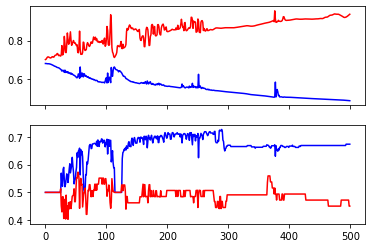

In [128]:
n_epochs = len(perf_df)

f, axs = plt.subplots(2, 1, sharex=True)
axs[0].plot(range(n_epochs), perf_df['train_loss'].values, 'b')
axs[0].plot(range(n_epochs), perf_df['valid_loss'].values, 'r')

axs[1].plot(range(n_epochs), perf_df['train_AUC'].values, 'b')
axs[1].plot(range(n_epochs), perf_df['valid_AUC'].values, 'r')
# axs[1].set_xlim([0, 150])
plt.show()

In [ ]:
learning_rate = 0.01
learning_rate_decay = 100
n_epochs = 50
weight_decay = 0

# learning_rate = 0.1 learning_rate_decay=True
epoch_losses = fit(model, criterion, learning_rate,\
                   train_dataloader, valid_dataloader, test_dataloader,\
                   learning_rate_decay, n_epochs, weight_decay)

In [141]:
# x_mean = tr_data[:,0,:,:].mean(axis=0).mean(axis=1)

# train_dataset = torch.utils.data.TensorDataset(torch.Tensor(tr_data),torch.Tensor(np.expand_dims(data.labels_tr, axis =1)),torch.Tensor(np.expand_dims(data.num_obs_times_tr-1, axis =1)))
# val_dataset = torch.utils.data.TensorDataset(torch.Tensor(va_data), torch.Tensor(np.expand_dims(data.labels_va, axis =1)),torch.Tensor(np.expand_dims(data.num_obs_times_va-1, axis =1)))
# x_mean = torch.Tensor(x_mean)

#needs int() bc hyperparameter script passes np.int64 and pytorch doesnt like that
#TODO add num_obs to dataset, then dataloader 

# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=int(batch_size), shuffle=True)
# val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size= int(batch_size), shuffle=True)


# print(va_data.shape)
# print(tr_data.shape)
# print('Data loaded!')
#print(tr_data[1])

input_size = 106 # num of variables
hidden_size = 106
output_size = 1
num_layers = 1 # num of GRU layers (only first layer is GRU-D)
seq_len = 25 # max seq len based on data
dropout=0

print("Build model with params:")
print("hidden_size: {}, dropout: {}, num_layers: {}".format(hidden_size,dropout,num_layers))

#fit the model

model = grud_model(input_size = input_size, hidden_size= int(hidden_size), 
                   output_size=output_size, dropout=dropout, dropout_type='mloss', 
                   x_mean=x_mean_F, num_layers=int(num_layers))


# use_cuda = torch.cuda.is_available()
# if use_cuda :
#     torch.backends.cudnn.benchmark = True
#     model = model.cuda()
#     print("Running on GPU")

criterion = torch.nn.BCELoss()
#untested
#logits=preds, targets=minibatch.O_dupe_onehot, pos_weight=self.class_imb)
#Get class imbalance (for weighted loss):
case_prev = y_train.sum()/float(len(y_train)) #get prevalence of cases in train dataset
class_imb = torch.tensor(1/case_prev) #class imbalance to use as class weight if losstype='weighted'
#TODO then we do not need to apply sigmoid to the model output in the model
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=class_imb)


# if len(_run.observers) > 0:
#      checkpoint_path = os.path.join(_run.observers[0].dir, 'model_checkpoints')
# else:
#     checkpoint_path = 'model_checkpoints'

# if not os.path.exists(checkpoint_path):
#     os.makedirs(checkpoint_path)
# print(model) 

l2_penalty = 1e-3
print('Begin training!')
AU_PRCs = fit(model, criterion, l2_penalty, learning_rate,\
               train_dataloader, valid_dataloader, test_dataloader,\
               learning_rate_decay, n_epochs)


print(AU_PRCs)
best_val = np.array(AU_PRCs).max()

Build model with params:
hidden_size: 106, dropout: 0, num_layers: 1
Begin training!
starting Epoch: 0
at epoch 0 learning_rate is updated to 0.005


RuntimeError: invalid argument 4: Index tensor must have same dimensions as input tensor at /opt/conda/conda-bld/pytorch_1573049304260/work/aten/src/TH/generic/THTensorEvenMoreMath.cpp:638

In [238]:
y_valid.sum()/len(y_valid)

0.3125

In [240]:
y_test.sum()/len(y_test)

0.34285714285714286